In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from copy import deepcopy
import matplotlib.pyplot as plt

C:\Users\yuhan\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%%time
df = pd.read_csv("../input/blocks.csv")

Wall time: 655 ms


In [4]:
print(df.shape)
df.head()

(2273345, 7)


,Level,latBlock,lngBlock,month,day,hour,ClientMacAddr
0,0,0,20,4,1,10,1
1,0,0,20,4,2,16,1
2,0,0,20,4,3,10,1
3,0,0,20,4,3,16,1
4,0,0,20,4,3,17,1


In [13]:
df_val = df.loc[df.month>=6]
df = df.loc[df.month<6]
print(df_val.shape)
print(df.shape)

(965179, 7)
(1308166, 7)


In [14]:
%%time
# format the input and output
def matrixTrans(df, level, between=7):
    tf = deepcopy(df.loc[df['Level'] == level])
    latMax = tf.latBlock.max()+1
    lngMax = tf.lngBlock.max()+1
    tf["order"] = tf.month * 10**2+ tf.day
    orders = sorted(tf["order"].unique())

    def generator():
        for hour in tf.hour.unique():
            yield hour

    g = generator()
    num = 0
    for h in g:
        num+= len(orders)-between
    features = np.zeros((num,lngMax,latMax,between))
    labels = np.zeros((num,lngMax,latMax))
    
    g = generator()
    index = 0
    for hour in g:
        temp = tf.loc[(tf.hour==hour)]
        for i in range(between, len(orders)):
            next_ = temp.loc[tf.order==orders[i]]
            for _,row in next_.iterrows():
                labels[index, row['lngBlock'],row['latBlock']] = row['ClientMacAddr']
            for b in range(between):
                prev = temp.loc[tf.order==orders[i-1-b]]
                for _, row in prev.iterrows():
                    features[index, row['lngBlock'],row['latBlock'],b] = row['ClientMacAddr']
            index += 1
            if index==num:
                return features, labels

    del tf
    features = features[:index,:,:,:]
    labels = labels[:index,:,:]
    return features, labels

features, labels = matrixTrans(df, 0)
features_val, labels_val = matrixTrans(df_val, 0)
print(features.shape)
print(labels.shape)

(1224, 60, 20, 7)
(1224, 60, 20)
Wall time: 4min 39s


In [18]:
def cnn_model(features, labels, mode):
    # Input Layer
    size = features.shape
    kernel_size = [(3,3),(2,2),(2,2),(1,1)]
    #pool_size = parameters.get("pool_size", [(2,2),(3,3),(2,2)])
    strides = [1,1,1]
    filters = [32, 16, 16,1]

    input_layer = tf.reshape(features, [-1, size[1], size[2], size[3]])
    label_layer = tf.reshape(labels, [-1, size[1]*size[2]])

    # We only add conv layers with 'same' padding in our model
    # since It's a n*n -> n*n prediction (previous distribution -> future prediction)
    # dimensions should be kept same

    # Convolutional Layer and Pooling Layer#1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=filters[0],
      kernel_size=kernel_size[0],
      padding="same",
      activation=tf.nn.elu)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=conv1,
      filters=filters[1],
      kernel_size=kernel_size[1],
      padding="same",
      activation=tf.nn.elu)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv3 = tf.layers.conv2d(
      inputs=conv2,
      filters=filters[2],
      kernel_size=kernel_size[2],
      padding="same",
      activation=tf.nn.elu)
    
    conv4 = tf.layers.conv2d(
      inputs=conv3,
      filters=filters[3],
      kernel_size=kernel_size[3],
      padding="same",
      activation=tf.nn.relu)

    # Dense Layer
    conv4_flat = tf.reshape(conv4, [-1, size[1]*size[2]*filters[3]])
    
    # Formerly, we use fully-connected layer to make output, 
    # but it costs too much computation resources and may lead to overfitting.
    # As an alternative, we use 1 filter in (1,1) size to make output.
    # Computing time and errors on val_data are reduced.
    #dense = tf.layers.dense(inputs=conv3_flat, units=1024)
    #dropout = tf.layers.dropout(inputs=dense, rate=0.8, training= mode == tf.estimator.ModeKeys.TRAIN)

    # Pred Layer
    pred = conv4_flat # tf.layers.dense(inputs=dropout, units= size[1]*size[2], activation=tf.nn.relu)

    # Loss
    loss = tf.losses.mean_squared_error(labels=label_layer, predictions=pred)
    
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "distribution": pred
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "mse": tf.metrics.mean_squared_error(
          labels=label_layer, predictions=pred)
    }
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [137]:
# Build the estimator
distribution_estimator = tf.estimator.Estimator(
    model_fn=cnn_model)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features,
    y=labels,
    num_epochs=None,
    shuffle=True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\yuhan\\AppData\\Local\\Temp\\tmpv3mdzsp2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001BB25D73CC0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [125]:
# Train the model
distribution_estimator.train(
    input_fn=train_input_fn,
    steps=100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp9cz1o_db\model.ckpt-3200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3200 into C:\Users\yuhan\AppData\Local\Temp\tmp9cz1o_db\model.ckpt.
INFO:tensorflow:loss = 192.02034, step = 3200
INFO:tensorflow:Saving checkpoints for 3300 into C:\Users\yuhan\AppData\Local\Temp\tmp9cz1o_db\model.ckpt.
INFO:tensorflow:Loss for final step: 208.90764.


In [126]:
# error on train dataset
# print out mse=401, then rmse = 20
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features,
    y=labels,
    num_epochs=1,
    shuffle=False)

eval_results = distribution_estimator.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-04:56:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp9cz1o_db\model.ckpt-3300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-04:56:02
INFO:tensorflow:Saving dict for global step 3300: global_step = 3300, loss = 277.71738, mse = 290.30673
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3300: C:\Users\yuhan\AppData\Local\Temp\tmp9cz1o_db\model.ckpt-3300
{'loss': 277.71738, 'mse': 290.30673, 'global_step': 3300}


In [127]:
# error on validation dataset
# print out mse=253, then rmse = 16
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features_val,
    y=labels_val,
    num_epochs=1,
    shuffle=False)

eval_results = distribution_estimator.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-04:56:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp9cz1o_db\model.ckpt-3300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-04:56:02
INFO:tensorflow:Saving dict for global step 3300: global_step = 3300, loss = 179.29213, mse = 194.78267
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3300: C:\Users\yuhan\AppData\Local\Temp\tmp9cz1o_db\model.ckpt-3300
{'loss': 179.29213, 'mse': 194.78267, 'global_step': 3300}


In [136]:
# the aim of rmse is 15, for now the rmse from cnn model is 20

In [140]:
# Train the CNN model step by step
trn_mse = []
val_mse = []
for i in range(100):
    distribution_estimator.train(
    input_fn=train_input_fn,
    steps=100)
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features,
    y=labels,
    num_epochs=1,
    shuffle=False)

    eval_results = distribution_estimator.evaluate(input_fn=eval_input_fn)
    trn_mse.append(eval_results)
    
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features_val,
    y=labels_val,
    num_epochs=1,
    shuffle=False)

    eval_results = distribution_estimator.evaluate(input_fn=eval_input_fn)
    val_mse.append(eval_results)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5000 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:loss = 351.92947, step = 5000
INFO:tensorflow:Saving checkpoints for 5100 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:Loss for final step: 121.12205.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:08:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-5100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init

INFO:tensorflow:loss = 227.97975, step = 5400
INFO:tensorflow:Saving checkpoints for 5500 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:Loss for final step: 300.4175.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:08:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-5500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:08:34
INFO:tensorflow:Saving dict for global step 5500: global_step = 5500, loss = 267.08014, mse = 279.18204
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5500: C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-5500
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:08:34
INFO:tensorflow:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:08:59
INFO:tensorflow:Saving dict for global step 5900: global_step = 5900, loss = 265.69098, mse = 277.72852
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5900: C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-5900
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:08:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-5900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:09:00
INFO:tensorflow:Saving dict for global step 5900: global_step = 5900, loss = 178.07777, mse = 193.46321
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5900: C:\Users\yuhan\AppData\Local\Te

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:09:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-6300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:09:26
INFO:tensorflow:Saving dict for global step 6300: global_step = 6300, loss = 177.23332, mse = 192.54576
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6300: C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-6300
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-6300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 63

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6700: C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-6700
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-6700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 6700 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:loss = 356.54193, step = 6700
INFO:tensorflow:Saving checkpoints for 6800 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:Loss for final step: 413.55444.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:09:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\User

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 7100 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:loss = 204.52765, step = 7100
INFO:tensorflow:Saving checkpoints for 7200 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:Loss for final step: 391.9303.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:10:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-7200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:10:23
INFO:tensorflow:Saving dict for global step 7200: global_step = 7200, loss = 259.32672, mse = 271.07132
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7200: C:\Users\yuhan\AppDa

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:10:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-7600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:10:49
INFO:tensorflow:Saving dict for global step 7600: global_step = 7600, loss = 257.48285, mse = 269.14087
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7600: C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-7600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:10:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-7600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_i

INFO:tensorflow:Saving dict for global step 8000: global_step = 8000, loss = 255.72519, mse = 267.30518
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8000: C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-8000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:11:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:11:15
INFO:tensorflow:Saving dict for global step 8000: global_step = 8000, loss = 179.32225, mse = 194.81517
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8000: C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-8000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaver

INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-8400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:11:41
INFO:tensorflow:Saving dict for global step 8400: global_step = 8400, loss = 183.87682, mse = 199.76338
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8400: C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-8400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-8400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8400 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:loss = 348.3785, step = 8400
INFO:tensorflow:Saving c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-8800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8800 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:loss = 317.8296, step = 8800
INFO:tensorflow:Saving checkpoints for 8900 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:Loss for final step: 244.73558.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:12:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-8900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_

INFO:tensorflow:loss = 254.16331, step = 9200
INFO:tensorflow:Saving checkpoints for 9300 into C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt.
INFO:tensorflow:Loss for final step: 169.84456.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:12:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-9300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:12:39
INFO:tensorflow:Saving dict for global step 9300: global_step = 9300, loss = 250.7513, mse = 262.09674
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9300: C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-9300
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:12:39
INFO:tensorflow:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:13:04
INFO:tensorflow:Saving dict for global step 9700: global_step = 9700, loss = 249.44585, mse = 260.72772
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9700: C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-9700
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-05:13:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmpv3mdzsp2\model.ckpt-9700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-05:13:04
INFO:tensorflow:Saving dict for global step 9700: global_step = 9700, loss = 183.73659, mse = 199.61101
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9700: C:\Users\yuhan\AppData\Local\Te

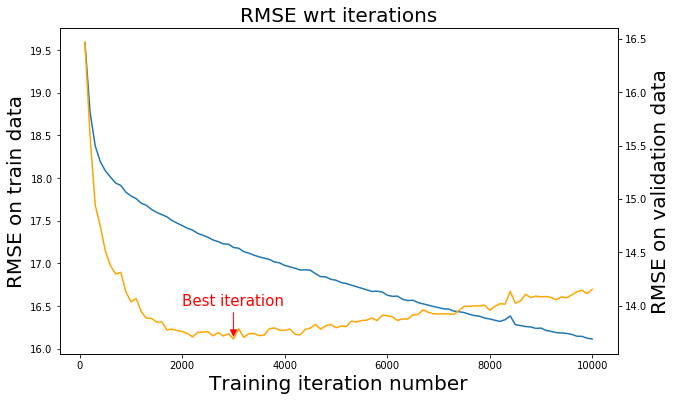

In [186]:
# Plot the result

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.plot([x["global_step"] for x in trn_mse],
        [x["mse"]**0.5 for x in trn_mse])
ax1.set_ylabel('RMSE on train data',size=20)
ax1.set_xlabel('Training iteration number',size=20)
ax1.set_title("RMSE wrt iterations",size=20)

ax2 = ax1.twinx()
ax2.plot([x["global_step"] for x in val_mse],
        [x["mse"]**0.5 for x in val_mse], 'orange')
ax2.set_ylabel('RMSE on validation data',size=20)

plt.annotate("Best iteration", xy=(3000,13.687),xytext = (2000,14),color="r",size=15,
             arrowprops={'arrowstyle':'-|>',"color":"r"})
plt.show()

In [193]:
# Best iteration is 3000
# Best RMSE on validation set is 13.68726477573279 (Target is <15)
print("The baseline RMSE:", 30)
print("The target RMSE:", 15)
print("best iteration:",val_mse[np.argmin([x["mse"] for x in val_mse])]["global_step"])
print("RMSE on train set:",trn_mse[np.argmin([x["mse"] for x in val_mse])]["mse"]**0.5)
print("best RMSE on validation data:",np.min([x["mse"]**0.5 for x in val_mse]))

The baseline RMSE: 30
The target RMSE: 15
best iteration: 3000
RMSE on train set: 17.186524297589685
best RMSE on validation data: 13.68726477573279
